# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
import plotly
import plotly.express as px

%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


None

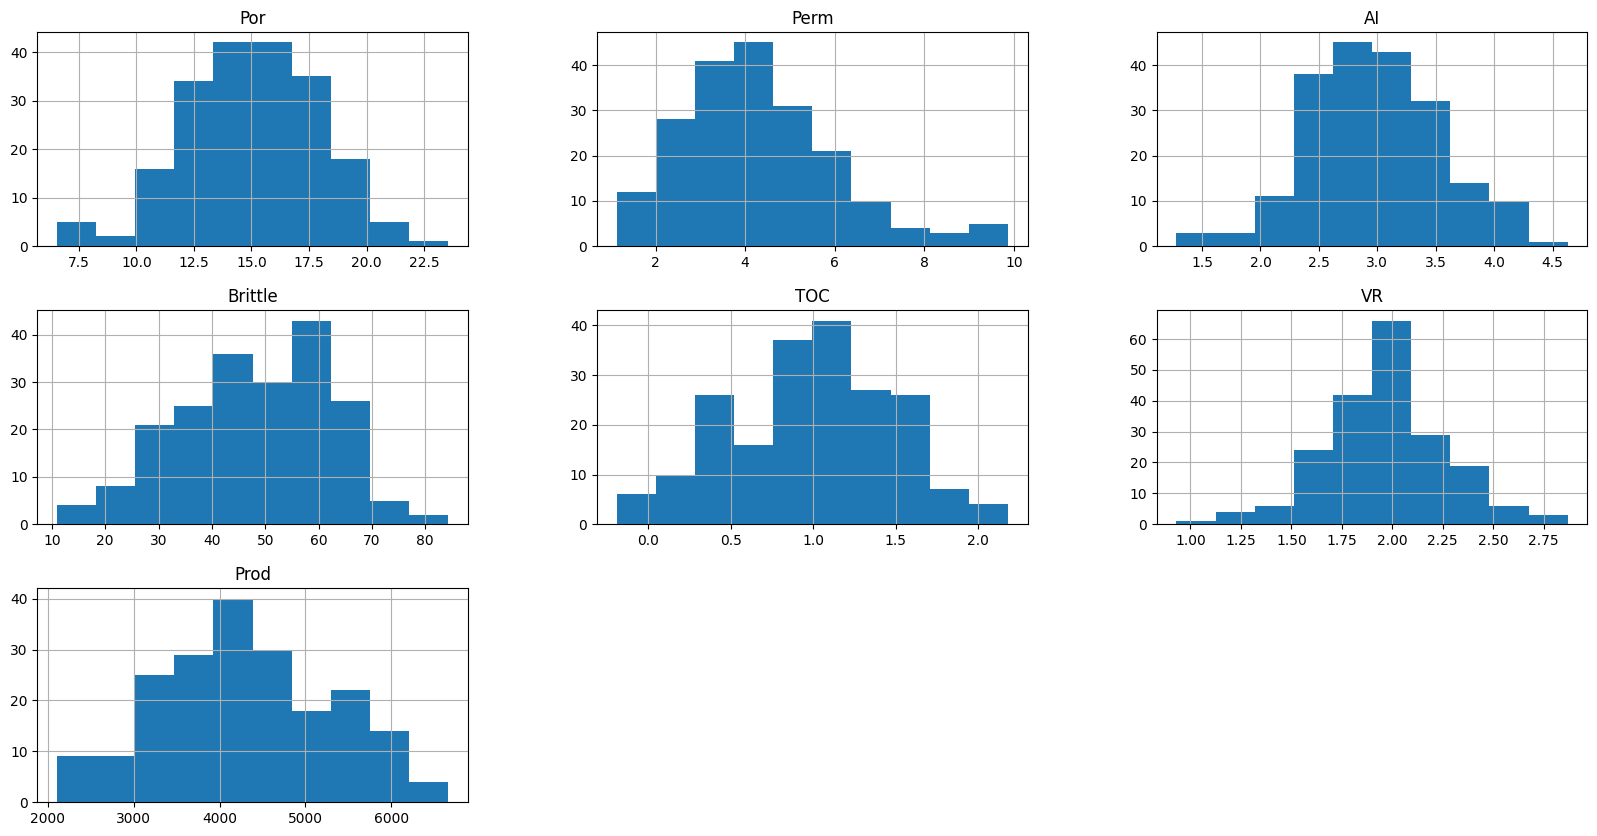

In [3]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data.dtypes
num_features = list(types[(types != 'object')].index)

fig = px.box(
    data_frame=data,
    x=num_features[1:7], # без целевого столбца и без well
    title='Статистические показатели в числовых признаках'
)
fig.update_layout(xaxis_title= 'Значение')
fig.show()

# посмотрим на распределение признаков
cols =  data.columns
data[cols[1:]].hist(figsize=(20, 10)); # без номера скважины

display(data.info())

Из представленных графиков, можно сделать вывод о том, что наши данные не имеют выбросов, большая часть признаков распределена нормально, в данных отсутствуют пропуски. Все признаки являются числовыми, а также видно, что необходимо нормализовать\стандартизовать признаки

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [4]:
# создадим переменую с данными для корреляции( до нормализации\стандартизации)
corr_data = data.corr()
fig = px.imshow(
    corr_data,
    text_auto=True,
    labels=(dict(color= 'Corr_coef'))
)
fig.show()
print('Rank:', np.linalg.matrix_rank(corr_data))
print('Determinant: {:.7f}'.format(np.linalg.det(corr_data)))

Rank: 8
Determinant: 0.0007299


> *Говоря о матрице корреляции, мы видим что с целевым признаком сильно коррелируются признаки Por, Perm, TOC, корреляция с которыми выше 0,65. Смотря на определитель мы видим, что данные матрица плохо обусловлена, так как определитель не сильно отличается от 0, матрица мультеколлениарна, полной колениарности нет, так как нету значений равных 1 в матрице. В данном случае линейная регрессия будет не достоверно находить значения так как имеется мультиколлениарность.*

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [5]:
# Создадим матрицу признаков добавив к ней единичный вектор 
X = np.column_stack((np.ones(200), data.drop('Prod', axis=1)))
y = data['Prod']
# посчитаем коэффициенты по формуле НМК
ols_coef = np.linalg.inv(X.T@X) @ X.T@y
print(ols_coef)

[-1.23230803e+03  5.07003631e-02  2.30179140e+02  1.16239006e+02
 -3.65202301e+02  2.49943700e+01 -7.84009294e+01  7.85259815e+02]


> *В наших даннных существует признак Por который, из ходя из полученных выше значений является не информативным. Если говорить о полученных коэфициентах, то можно сделать следующие интерпритации. Например при уыеличении проницаемости скважины на 1 условную еденицу, искомое значение будет увеличиваться на 230 едениц, при уменьшении хрупкости скважины на 10 процентов, искомое значение также уменьшится на 250 едениц, говоря о содержании углерода, при его увеличении на 1 еденицу искомое значение уменьшится 78.*

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [6]:
# короткий способ сделать прогноз
df_new = [106.0, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42]
new=np.array([[1, 106.0, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42]])
print('prediction:', (new@ols_coef))
print(4748.315024 - new@ols_coef)
y_pred = X@ols_coef
from sklearn import metrics

print('MAPE score: {:.1f} %'.format(metrics.mean_absolute_percentage_error(y, y_pred) * 100))
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_pred)))

prediction: [4723.06405371]
[25.25097029]
MAPE score: 3.6 %
R2 score: 0.960


> *Исходя из полученых значений метрик, можно сделать следующие выводы, что на данных сырых данных, модель справляется с предсказанием конкретного значения с средней абсолютной ошибкой в рамзере 3.6%, если смотреть по r_2 то наша модель справилась практически идеально, при максимальном значении 1, и она уловила почти максмильную дисперсию в данных.*

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

[-1.23230803e+03  5.07003631e-02  2.30179140e+02  1.16239006e+02
 -3.65202301e+02  2.49943700e+01 -7.84009294e+01  7.85259815e+02]


<AxesSubplot: xlabel='TOC', ylabel='Prod'>

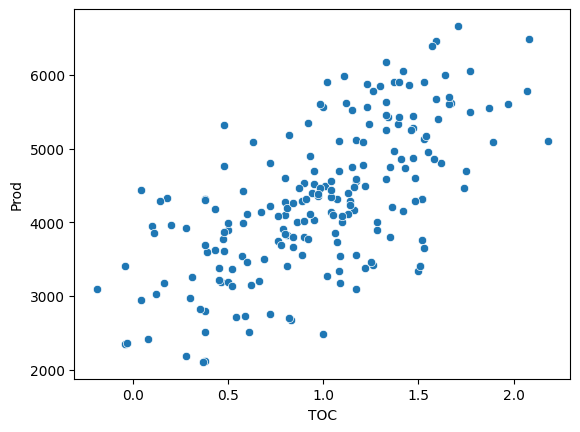

In [7]:
# выведем значением коэфициентов в модели
print(ols_coef)
# Построим диаграмма расеивания на основе матрицы корееляции целевого признака
fig = px.scatter(corr_data['Prod'])
fig.show()
# Построим зависимость значений prod - TOC
sns.scatterplot(x='TOC', y='Prod', data=data)


> *Исходя из полученной таблицы значений корреляции с целевым признаком и значениями коэфициентов нашей модели, мы видим, что корреляция прямая, а в модели коэфициент показывает обратную зависимость, хотя здесь определенно прямая зависимость, так как содержания углеводорода в скважине напрямую зависит от того, сколько будет добываться газа. В этом мы можем убедиться если построим график зависимости TOC от Prod. Данная ситуация может получиться в связи с тем что у нас есть мультиколениарность в данных,  в связи с чем могут не верно интерпритироваться коэфициенты.*

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [8]:
# создадим новую матрицу признаков без целевого признака и признаков которые мультиколлениарны
# Создадим матрицу признаков добавив к ней единичный вектор 
X = np.column_stack((np.ones(200), data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)))
y = data['Prod']
# посчитаем коэффициенты по формуле НМК
ols_coef_new = np.linalg.inv(X.T@X) @ X.T@y
print(ols_coef_new)

y_pred_new = X@ols_coef_new

# Расчитаем метрики
print('MAPE score: {:.1f} %'.format(metrics.mean_absolute_percentage_error(y, y_pred_new) * 100))
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_pred_new)))

[-1835.44646069   293.03624565  -200.03091206    27.64098209
   517.40272597]
MAPE score: 4.0 %
R2 score: 0.945


> *Говоря о полученых коэфициентах, мы можем сказать, что при увеличении на одну еденицу Por мы увеличим нашу целевую метрику на 293 еденицы, а если увеличить AI, то мы уменьшим наше целевое значение на 200, говоря о том как ранее были найдены данные коэфициенты, можем сказать следующее направление не изменилось, но изменения немного уменьшелись, ранее коэфиценты были выше. Исходя из полученых значений метрик, можно сделать следующие выводы, что на данных сырых данных, модель справляется с предсказанием конкретного значения с средней абсолютной ошибкой в рамзере 4%, если смотреть по r_2 то наша модель справилась практически идеально, при максимальном значении 1, и она уловила почти максмильную дисперсию в данных. Значения метрик немного ухудшились по сравнению с предыдушимим. Вместе с тем, нам удолось побороть противоречия коэфициентов и значения корреляции, теперь они не противоречат друг другу.*

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
print('MAPE score: {:.1f} %'.format(metrics.mean_absolute_percentage_error(y, y_pred) * 100))
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_pred)))

MAPE score: 4.0 %
R2 score: 0.945


> *Из полученных результатов по средствам построения линейной регрессии, мы видим, что при помоши матричного вида в ручную, мы получие такие же результаты, что и при использовании линейной регрессии.*

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [10]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [11]:
X = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
y = data['Prod']
# Зададим скеллер
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Генерация полиномиальных признаков
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X_scaled)


# Вывод количества факторов после генерации полиномиальных признаков
num_features = X_poly.shape[1]
print("Количество факторов после генерации полиномиальных признаков:", num_features)


# Зададим модель линенйной регрессии и обучим ее
lr_model = LinearRegression().fit(X_poly,y)
cv_results = cross_validate(lr_model, X_poly, y, scoring=['neg_mean_absolute_percentage_error','r2'], cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_neg_mean_absolute_percentage_error'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100)) 
print('r2 на тренировочных фолдах: {:.2f} %'.format(cv_results['train_r2'].mean()* 100))
print('r2 на валидационных фолдах: {:.2f} %'.format(cv_results['test_r2'].mean() * 100))

Количество факторов после генерации полиномиальных признаков: 34
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %
r2 на тренировочных фолдах: 98.96 %
r2 на валидационных фолдах: 97.48 %


> *Как мы видим из полученных результатов, при помоши полиномиальных признаков мы получили 34 фактор, и использую кросс валидацию на 5 фолдах, мы улучшили значения метрик, так как смогли более точно подобрать коэфициенты на тренировочных данных и применить их на валидационную часть. Так мы видим что ранее у нас метрика МАЕ была 4% здесь мы получаем на валидационных данных значение 2.68% а на тренировочных и того 1.77%, тоже можно сказать и $R^2$ поднялось значение с 94 до 98*

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [43]:
# Зададим модель lasso
lasso = Lasso()

# Задание значения гиперпараметра alpha для перебора
alpha_list = {'alpha':list(np.linspace(0.01, 10, 20, dtype=float))}

# найдем лучшие значения через gridsearch
grid_search = GridSearchCV(estimator=lasso, param_grid=alpha_list, cv=5, n_jobs=-1).fit(X_poly, y)

# Получение лучшей модели с оптимальным значением alpha
best_model_lasso = grid_search.best_estimator_


# Вычисление среднего значения метрики MAPE на тренировочных и валидационных фолдах с использованиемcv_resul кросс-валидации
cv_results_lasso = cross_validate(best_model_lasso, X_poly, y, scoring=['neg_mean_absolute_percentage_error','r2'], cv=5, return_train_score=True)


print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results_lasso['train_neg_mean_absolute_percentage_error'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results_lasso['test_neg_mean_absolute_percentage_error'].mean() * 100)) 
print('r2 на тренировочных фолдах: {:.2f} %'.format(cv_results_lasso['train_r2'].mean()* 100))
print('r2 на валидационных фолдах: {:.2f} %'.format(cv_results_lasso['test_r2'].mean() * 100))
print(best_model_lasso)

MAPE на тренировочных фолдах: 1.86 %
MAPE на валидационных фолдах: 2.28 %
r2 на тренировочных фолдах: 98.80 %
r2 на валидационных фолдах: 98.24 %
Lasso(alpha=6.319473684210527)


> *Из полученных результатов мы видим, что при помоши модели Lasso  нам удалось улучшить только метрику MAPE на валидационных фолдах, остальные метрики немного ухудшились, но в целом остались без изменений. Из чего можно сделать вывод, что данный метод не влияет на наших данных.*

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [48]:
# Зададим модель lasso
ridge = Ridge()

# Задание значения гиперпараметра alpha для перебора
alpha_list = {'alpha':list(np.linspace(0.01, 10, 20, dtype=float))}

# найдем лучшие значения через gridsearch
grid_search = GridSearchCV(estimator=ridge, param_grid=alpha_list, cv=5, n_jobs=-1).fit(X_poly, y)

# Получение лучшей модели с оптимальным значением alpha
best_model_ridge = grid_search.best_estimator_


# Вычисление среднего значения метрики MAPE на тренировочных и валидационных фолдах с использованиемcv_resul кросс-валидации
cv_results_ridge = cross_validate(best_model_ridge, X_poly, y, scoring=['neg_mean_absolute_percentage_error','r2'], cv=5, return_train_score=True)


print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results_ridge['train_neg_mean_absolute_percentage_error'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results_ridge['test_neg_mean_absolute_percentage_error'].mean() * 100)) 
print('r2 на тренировочных фолдах: {:.2f} %'.format(cv_results_ridge['train_r2'].mean()* 100))
print('r2 на валидационных фолдах: {:.2f} %'.format(cv_results_ridge['test_r2'].mean() * 100))
print(best_model_ridge)

MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.72 %
r2 на тренировочных фолдах: 98.92 %
r2 на валидационных фолдах: 97.54 %
Ridge(alpha=1.0615789473684212)


> *При помоши модели ridge нам снова незначительно удалось улучшить одну из метрик, но только на тренировочных данных, на валидационных данных у нас небольшое снижение показателей.*

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [50]:
# Зададим модель lasso
elastic_net = ElasticNet()

# Задание значения гиперпараметра alpha для перебора
alpha_list = {'alpha':list(np.linspace(0.01, 10, 20, dtype=float)),
              'l1_ratio':list(np.linspace(0.01, 1, 20, dtype=float))}

# найдем лучшие значения через gridsearch
grid_search = GridSearchCV(estimator=elastic_net, param_grid=alpha_list, cv=5, n_jobs=-1).fit(X_poly, y)

# Получение лучшей модели с оптимальным значением alpha
best_model_en = grid_search.best_estimator_


# Вычисление среднего значения метрики MAPE на тренировочных и валидационных фолдах с использованиемcv_resul кросс-валидации
cv_results_en = cross_validate(best_model_en, X_poly, y, scoring=['neg_mean_absolute_percentage_error','r2'], cv=5, return_train_score=True)


print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results_en['train_neg_mean_absolute_percentage_error'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results_en['test_neg_mean_absolute_percentage_error'].mean() * 100)) 
print('r2 на тренировочных фолдах: {:.2f} %'.format(cv_results_en['train_r2'].mean()* 100))
print('r2 на валидационных фолдах: {:.2f} %'.format(cv_results_en['test_r2'].mean() * 100))
print(best_model_en)


MAPE на тренировочных фолдах: 1.86 %
MAPE на валидационных фолдах: 2.28 %
r2 на тренировочных фолдах: 98.80 %
r2 на валидационных фолдах: 98.24 %
ElasticNet(alpha=6.319473684210527, l1_ratio=1.0)


> *По модели Elastic Net мы видим отличные значения от двух предыдуших методов, в целом данные значения метрик не сильно отличаются от чисто линейной регрессии, но всеже немного лучше. Если нам нужна более точное зрначение то мы можем воспользоваться данным методом регуляризации.*

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [56]:
# Зададим модель линенйной регрессии и обучим без полиномиальных признаковее на кросс валидации для наглядности
lr_model = LinearRegression().fit(X,y)
cv_results_1 = cross_validate(lr_model, X, y, scoring=['neg_mean_absolute_percentage_error','r2'], cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results_1['train_neg_mean_absolute_percentage_error'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results_1['test_neg_mean_absolute_percentage_error'].mean() * 100)) 
print('r2 на тренировочных фолдах: {:.2f} %'.format(cv_results_1['train_r2'].mean()* 100))
print('r2 на валидационных фолдах: {:.2f} %'.format(cv_results_1['test_r2'].mean() * 100))

MAPE на тренировочных фолдах: 4.02 %
MAPE на валидационных фолдах: 4.23 %
r2 на тренировочных фолдах: 94.56 %
r2 на валидационных фолдах: 93.80 %


In [60]:
# Составим сводную таблицу из полученных моделей
finished_df = pd.DataFrame(
    data = [
        ['LinearRegression', 
         np.nan, 
         False, 
         (round(-cv_results_1['train_neg_mean_absolute_percentage_error'].mean()* 100, 2)), 
         (round(-cv_results_1['test_neg_mean_absolute_percentage_error'].mean() * 100, 2))
         ],
        ['LinearRegression', 
         np.nan, 
         True, 
         (round(-cv_results['train_neg_mean_absolute_percentage_error'].mean()* 100, 2)), 
         (round(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100, 2))
         ],
        ['Lasso_model',
         best_model_lasso,
         True,
         (round(-cv_results_lasso['train_neg_mean_absolute_percentage_error'].mean()* 100, 2)), 
         (round(-cv_results_lasso['test_neg_mean_absolute_percentage_error'].mean() * 100, 2))
         ],
        ['Ridge_model',
         best_model_ridge,
         True,
         (round(-cv_results_ridge['train_neg_mean_absolute_percentage_error'].mean()* 100, 2)), 
         (round(-cv_results_ridge['test_neg_mean_absolute_percentage_error'].mean() * 100, 2))
         ],
        ['Elastic Net model',
         best_model_en,
         True,
         (round(-cv_results_en['train_neg_mean_absolute_percentage_error'].mean()* 100, 2)), 
         (round(-cv_results_en['test_neg_mean_absolute_percentage_error'].mean() * 100, 2))
         ]
    ],
    columns= ['Наименование модели', 
              'Коэффициенты регуляризации', 
              'Использовался ли полиномиальный признак',
              'Значение метрики MAPE на тренировочных фолдах при кросс валидации',
              'Значение метрики MAPE на валидационных фолдах при кросс валидации'
    ]
)
display(finished_df)

,Наименование модели,Коэффициенты регуляризации,Использовался ли полиномиальный признак,Значение метрики MAPE на тренировочных фолдах при кросс валидации,Значение метрики MAPE на валидационных фолдах при кросс валидации
0,LinearRegression,NaN,False,4.02,4.23
1,LinearRegression,NaN,True,1.77,2.68
2,Lasso_model,Lasso(alpha=6.319473684210527),True,1.86,2.28
3,Ridge_model,Ridge(alpha=1.0615789473684212),True,1.83,2.72
4,Elastic Net model,"ElasticNet(alpha=6.319473684210527, l1_ratio=1.0)",True,1.86,2.28


> *Из преведнного нами анализы представленных данных о компании «Газ-Таз-Ваз-Нефть» мы можем выделить 4 признака которые влияют на добычу газа в скважине, а именно 'Well', 'Perm', 'TOC', 'Prod'. Обучив несколько различных моделей для предсказания добычи газа в сутки по выделенным факторам, можно сказать, что самым оптимальным вариантом будет являться модели Lasso/ Elastic Net которые имеют наименьшую среднюю абсолютную ошибку в процентах, что обеспечит натбольшую вероятность предсказания точно объема добытого газа в новых скважинах.  *